In [16]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits

# Simulation dataset

In [61]:
catalog = "../assets/RXTE-ASM_BeppoSAX-WFC_catalog_new.fits"
data = fits.getdata(catalog, ext=1)

We visualize the average fluxes:

In [65]:
logbins = np.logspace(*np.log10(np.percentile(data["AVG_FLUX"], [0, 100])))
counts, _ = np.histogram(fluxes, bins=logbins)

[]

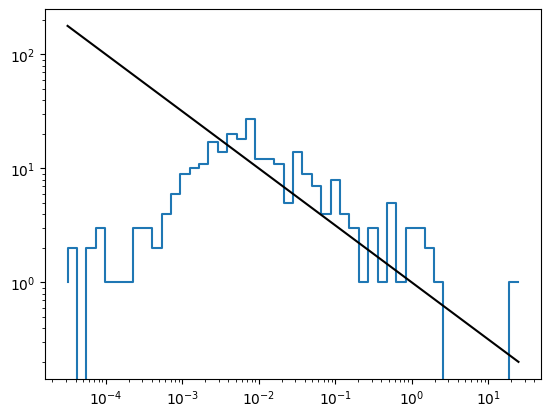

In [82]:
plt.step(logbins[:-1], counts)
plt.plot(logbins[:-1], p(logbins[:-1]), color="k")
plt.loglog()

A power law is discernible. The powerlaw interrupts at low fluxes likely due to a selection bias. The power law index is around 0.5, which means we have ~10 time more sources with flux ~0.01 than we have we have with flux 1.


[]

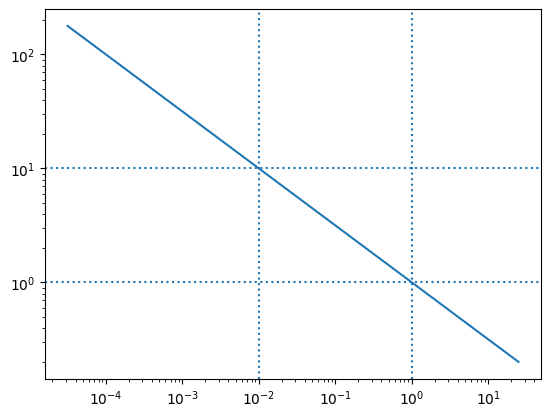

In [93]:
def p(x):
    return 1 / x ** .5

plt.plot(logbins[:-1], p(logbins[:-1]))
plt.axvline(.01, ls=":")
plt.axhline(10, ls=":")
plt.axvline(1, ls=":")
plt.axhline(1, ls=":")
plt.loglog()

In [94]:
def inversion_sampling(
    size: int,
    bins: np.ndarray,
    probability: np.ndarray,
) -> np.ndarray:
    """
    Fast inversion sampling from discrete distribution.
    Does not require bins to be equispaced.
    :param size: number of samples to draw
    :param bins: bin edges (len n + 1)
    :param probability: unnormalized probability values (len n).
    :return: !!unsorted!! samples
    """
    probability_cdf = np.cumsum(probability)
    ys = np.random.rand(size) * probability_cdf[-1]
    ii = np.searchsorted(probability_cdf, ys)
    top_edges = bins[ii + 1]
    samples = top_edges - np.random.rand(size) * (top_edges - bins[ii])
    return samples

Let's sample from this powerlaw. But how many? Over the entire sky we have a number of sources with fluxes greater than 0.01:

In [117]:
len(data[data["AVG_FLUX"] > 0.01])

131

Assuming the partially coded field of view to extend between -45° and +45°, if the sources were uniformly distributed we would expect from a random field, on average:

In [119]:
avg_sources_pcfov = len(data[data["AVG_FLUX"] > 0.01]) * 45 * 45 / 41253
avg_sources_pcfov

6.430441422442004

So let's sample a number of source from poisson with rate as above:

In [136]:
from scipy.stats import poisson

logbins = np.logspace(-2, 2, 100)
mcsources = inversion_sampling(poisson(avg_sources_pcfov).rvs(), logbins[:-1], p(logbins))

In [137]:
mcsources

array([3.29087506e+00, 3.45658813e+01, 1.54555137e-02, 1.69810477e+00,
       9.60135026e-01, 1.20802398e-01, 1.81645161e-02])

Now we have to sample the source directions. We simply pick random angles between +-45°. Note this will result in a non-uniform source distribution on the celestial sphere. Francesco reports RA and DEC in degrees, over the ranges (0, 360) and (-90, +90).°

In [366]:
def generate_coords(
        nsize: int,
        pointing: tuple,  # degrees
        pcfov:  tuple,  # degrees
):
    ra_p, dec_p = pointing
    ra_fov, dec_fov = pcfov
    rands = np.random.rand(nsize, 2) * 2 - 1
    rands *= np.array([ra_fov, dec_fov])
    rands += np.array([ra_p, dec_p])
    # crash if badly constrained angle, will fix later if needed
    assert not any(rands[:, 0] > 360) and not any(rands[:, 0] < 0)
    assert not any(rands[:, 1] > +90) and not any(rands[:, 0] < -90)
    return rands


generate_coords(10, (180., 0) , (45, 45))

array([[191.06933134, -23.10611815],
       [169.03826884, -44.02123485],
       [176.08804023,  29.31780963],
       [214.11607947, -23.29735457],
       [175.22706765, -28.13750932],
       [216.4873531 , -19.53601943],
       [145.2838684 ,  41.37333464],
       [171.14375568,   7.37200427],
       [155.58373802, -30.40246982],
       [191.39443822, -11.41621646]])

Putting together:

In [367]:
import pandas as pd

pointing = (180, 45)
fluxes = inversion_sampling(poisson(avg_sources_pcfov).rvs(), logbins, p(logbins))
coords = generate_coords(len(fluxes), pointing , (45, 45))

catalog = pd.DataFrame({
    "ID": [f"s{n:02}" for n in range(len(coords))],
    "NAME": [f"s{n:02}" for n in range(len(coords))],
    "RA": coords[:, 0],
    "DEC": coords[:, 1],
    "AVG_FLUX": fluxes,
})
catalog

,ID,NAME,RA,DEC,AVG_FLUX
0,s00,s00,161.588608,44.177035,0.010180
1,s01,s01,177.133437,86.340496,0.364316
2,s02,s02,144.604339,49.126543,4.150865


We are still missing some data for our fake catalogs:

In [368]:
data.columns

ColDefs(
    name = 'ID'; format = '16A'
    name = 'NAME'; format = '20A'
    name = 'RA'; format = 'E'; unit = 'deg'
    name = 'DEC'; format = 'E'; unit = 'deg'
    name = 'AVG_FLUX'; format = 'E'; unit = 'ph.s-1.cm-2'
    name = 'CODE'; format = 'B'
    name = 'FORMULA'; format = '16A'
    name = 'INDEX'; format = 'E'
    name = 'NH'; format = 'E'
    name = 'ENERGY'; format = '513E'; unit = 'keV'
    name = 'SPECTRUM'; format = '512E'; unit = 'ph.s-1.cm-2.keV-1'
)

Honestly I am unsure on how the remaining entries should be filled. I will sample rows at random from the catalog for filling these.

In [369]:
random_rows = np.random.choice(data, len(coords), replace=False)

In [370]:
from astropy.io import fits
import numpy as np


cs = [
    fits.Column(
        name=col.name,
        array=catalog[col.name] if col.name in catalog else random_rows[col.name],
        format=col.format,
        unit=col.unit
    )
    for col in data.columns
]
t = fits.BinTableHDU.from_columns(cs)
t.writeto(.., overwrite=True)